# Prepare some things

## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

import sklearn.metrics
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

In [2]:
# Load the VaDE model class and some custom functions
from models import get_vade_models
from evaluate_model import evaluate_clustering_performance
from draw_embeddings import draw_embeddings, draw_clusters_assignments, compare_reconstructed_images_MNIST

## Load and prepare the MNIST data set

In [3]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

x_train = x_train.reshape(-1, 28*28).astype("float")/255
x_test = x_test.reshape(-1, 28*28).astype("float")/255

# Pretrain the model

## Construct the AE encoder and decoder modules

## Construct the models and pretrain the autoencoder

In [4]:
IMG_DIM = 28*28
LATENT_DIM = 10
INTERMEDIATE_DIMS = (512, 512, 2048)
N_CLASSES = 10

EPOCHS = 20
LEARNING_RATE = 0.001
BATCH_SIZE = 128

model_pretrain, model_vade = get_vade_models(N_CLASSES, IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)

# model_pretrain.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#                        loss=keras.losses.BinaryCrossentropy(reduction='sum'))

# model_pretrain.fit(x_train, x_train,
#                    epochs=EPOCHS,
#                    batch_size=BATCH_SIZE,
#                    verbose=2,
#                   )

# model_pretrain.encoder.save_weights("model_weights/vade/pretrained/encoder")
# model_pretrain.decoder.save_weights("model_weights/vade/pretrained/decoder")

model_pretrain.encoder.load_weights("model_weights/vade/pretrained/encoder")
model_pretrain.decoder.load_weights("model_weights/vade/pretrained/decoder")

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


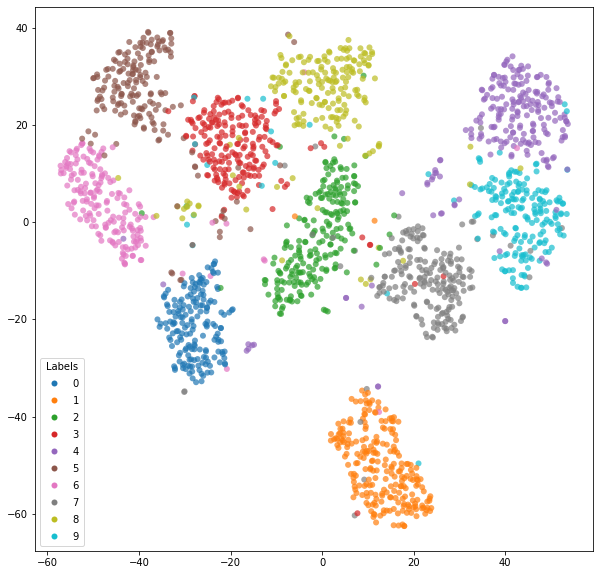

In [5]:
z = model_pretrain.encode(x_test[0:2000])

tsne = TSNE(n_components=2, init='pca')
z_tsne = tsne.fit_transform(z)
draw_embeddings(z_tsne, y_test[0:2000], alpha=0.7)

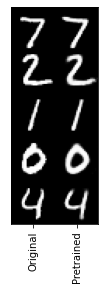

In [6]:
compare_orig_vs_pretrained = compare_reconstructed_images_MNIST(x_test, model_pretrain.encoder, model_pretrain.decoder, ("Original", "Pretrained"))

# Fine-tune the model

## Construct the full VaDE model

Load the pretrained weights for the encoder and decoder modules:

In [7]:
model_pretrain.encoder.load_weights("model_weights/vade/pretrained/encoder")
model_pretrain.decoder.load_weights("model_weights/vade/pretrained/decoder")

## Initialize the parameters

Initialize the model parameters from a GMM model:

In [8]:
# z_train = model_vade.encode_only_mu(x_train)

# gmm = GaussianMixture(n_components=N_CLASSES, covariance_type='diag', n_init=10)
# gmm.fit(z_train)

# for weight in model_vade.trainable_weights:
#     if weight.name == "pi:0":
#         weight.assign(K.log(K.constant(gmm.weights_)))
#     elif weight.name == "mu:0":
#         weight.assign(K.constant(gmm.means_))
#     elif weight.name == "logvar:0":
#         weight.assign(K.log(K.constant(gmm.covariances_)))

model_vade.load_weights("model_weights/vade/pretrained/vade")

Evaluate the clustering performance before fine-tunning the model:

Acc: 0.8550
ARI: 0.7159
AMI: 0.7460
Sil: 0.1344


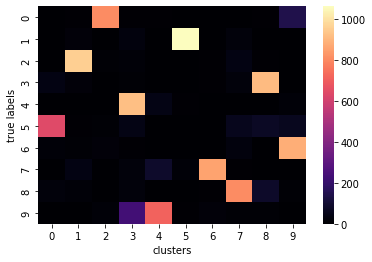

In [9]:
evaluate_clustering_performance(model_vade.classify, x_test, y_test, True, model_vade.encode_only_mu)

In [10]:
# model_vade.save_weights("model_weights/vade/pretrained/vade")

## Train the model

Prepare some custom callbacks: every 10 epochs, we will decrease de learning rate and print the clustering accuracy on the test dataset.

In [11]:
def scheduler(epoch, lr):
    if (epoch+1) % SCHEDULE == 0:
        lr = lr * 0.9
    return lr

def print_accuracy(epoch, logs):
    if (epoch+1) % SCHEDULE == 0:
        c_test = model_vade.classify(x_test)
        confusion_matrix = sklearn.metrics.confusion_matrix(y_test, c_test)
        c_test = confusion_matrix.argmax(0)[c_test]
        print(f"Current accuracy on test dataset: {sklearn.metrics.accuracy_score(y_test, c_test):.4f}")

callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.LambdaCallback(on_epoch_end=print_accuracy)]

Train the model:

In [12]:
EPOCHS = 200
LEARNING_RATE = 0.002
BATCH_SIZE = 128
SCHEDULE = 10

# model_vade.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# model_vade.fit(x_train,
#                epochs=EPOCHS,
#                batch_size=BATCH_SIZE,
#                callbacks = callback,
#                verbose=2,
#               )

# model_vade.save_weights("model_weights/vade/finetuned/vade")

model_vade.load_weights("model_weights/vade/finetuned/vade")

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


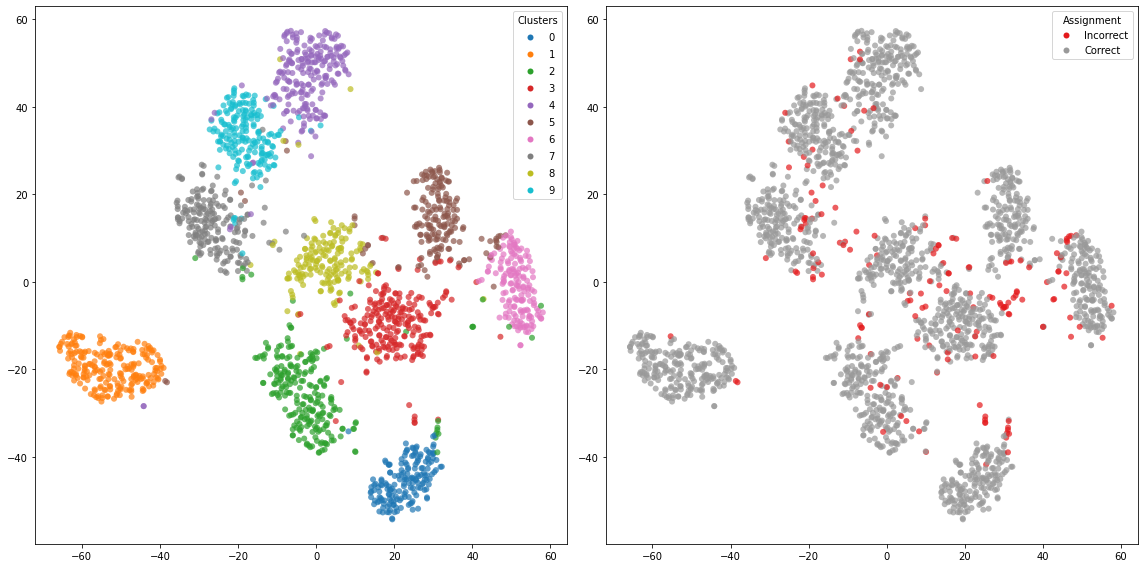

In [13]:
z = model_vade.encode_only_mu(x_test[0:2000])
tsne = TSNE(n_components=2, init='pca')
z_tsne = tsne.fit_transform(z)
c_test = model_vade.classify(x_test)
draw_clusters_assignments(z_tsne, y_test[0:2000], c_test[0:2000], alpha=0.7)

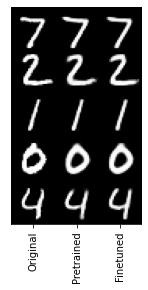

In [14]:
_ = compare_reconstructed_images_MNIST(x_test, model_vade.encoder, model_vade.decoder, ("Original", "Pretrained", "Finetuned"), old_figure=compare_orig_vs_pretrained)

## Evaluate the model

Acc: 0.9414
ARI: 0.8769
AMI: 0.8760
Sil: 0.2260


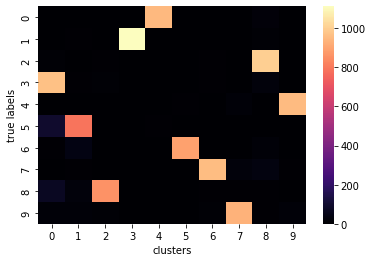

In [15]:
evaluate_clustering_performance(model_vade.classify, x_test, y_test, True, model_vade.encode_only_mu)